# 6. ONNX model deployment into ACI

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

## 1. Intro

In [53]:
import sys
print("Python version :",sys.version)

Python version : 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [54]:
import datetime
maintenant = datetime.datetime.now()
print(maintenant)

2020-09-22 07:34:32.306675


In [55]:
#Version
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.13.0


In [56]:
import urllib.request
onnx_model_url = "https://www.cntk.ai/OnnxModels/mnist/opset_7/mnist.tar.gz"
urllib.request.urlretrieve(onnx_model_url, filename="mnist.tar.gz")

('mnist.tar.gz', <http.client.HTTPMessage at 0x7fd1f28f2898>)

In [57]:
!tar xvzf mnist.tar.gz

mnist/
mnist/model.onnx
mnist/test_data_set_0/
mnist/test_data_set_0/input_0.pb
mnist/test_data_set_0/output_0.pb
mnist/test_data_set_1/
mnist/test_data_set_1/input_0.pb
mnist/test_data_set_1/output_0.pb
mnist/test_data_set_2/
mnist/test_data_set_2/input_0.pb
mnist/test_data_set_2/output_0.pb


## 2. Connection workspace Azure ML


In [58]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, sep = '\n')

workshopAML2020
workshopAML2020-rg
westeurope


## 3. Référencement du modèle

In [31]:
model_dir = "mnist" # replace this with the location of your model files

# leave as is if it's in the same folder as this notebook

In [76]:
%ls \mnist\*

ls: cannot access 'mnist*': No such file or directory


In [59]:
from azureml.core.model import Model

model = Model.register(workspace = ws,
                       model_path = model_dir + "/" + "model.onnx",
                       model_name = "mnistMLmodel",
                       tags = {"Source": "ONNX"},
                       description = "MNIST image classification CNN from ONNX Model Zoo",)

Registering model mnistMLmodel


In [77]:
print('Nom du modèle :', model.name)
print('Description :', model.description)
print('ID =', model.id)
print('Version =', model.version)

Nom du modèle : mnistMLmodel
Description : MNIST image classification CNN from ONNX Model Zoo
ID = mnistMLmodel:1
Version = 1


In [78]:
# Liste des modèles référencés dans le workspace
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, '- version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

mnistMLmodel - version = 1
	 Source : ONNX


mnist_model - version = 9
	 Source : Onnx


mnist_model - version = 8
	 Source : Onnx


amlstudio-failures-real-time-i - version = 1
	 CreatedByAMLStudio : true


regressionml - version = 1
	 area : diabetes
	 type : regression


DiabetesRidge - version = 9
	 area : Diabetes
	 type : Regression Ridge
	 k : 0.4
	 MSE : 3295.74
	 R2 : 0.36
	 RMSE : 57.41
	 Framework : Azure ML SDK


DiabetesRidge - version = 8
	 area : Diabetes
	 type : Regression Ridge
	 k : 0.4
	 MSE : 3295.74
	 R2 : 0.36
	 RMSE : 57.41
	 Framework : Azure ML SDK


amlstudio-defect-real-time-inf - version = 3
	 CreatedByAMLStudio : true


sklearnregressionmodel.pkl - version = 1
	 area : diabetes
	 type : regression


Defect - version = 6
	 Training context : Azure Auto ML SDK
	 AUC : 0.7783030303030303
	 Accuracy : 0.8586956521739131


amlstudio-defect-real-time-inf - version = 2
	 CreatedByAMLStudio : true


Modele-SKLEARN-Regression - version = 16
	 area : diabetes
	 type

In [60]:
# for images and plots in this notebook
import matplotlib.pyplot as plt  
from IPython.display import Image

# display images inline
%matplotlib inline

In [61]:
Image(url="http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

## 4. Déploiement


### 4.1 Score File


In [62]:
%%writefile scoreonnxaci.py
import json
import numpy as np
import onnxruntime
import sys
import os
import time


def init():
    global session, input_name, output_name
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'model.onnx')
    session = onnxruntime.InferenceSession(model, None)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name 
    

def preprocess(input_data_json):
    # convert the JSON data into the tensor input
    return np.array(json.loads(input_data_json)['data']).astype('float32')

def postprocess(result):
    # We use argmax to pick the highest confidence label
    return int(np.argmax(np.array(result).squeeze(), axis=0))
    
def run(input_data):

    try:
        # load in our data, convert to readable format
        data = preprocess(input_data)
        
        # start timer
        start = time.time()
        
        r = session.run([output_name], {input_name: data})
        
        #end timer
        end = time.time()
        
        result = postprocess(r)
        result_dict = {"result": result,
                      "time_in_sec": end - start}
    except Exception as e:
        result_dict = {"error": str(e)}
    
    return result_dict

def choose_class(result_prob):
    """We use argmax to determine the right label to choose from our output"""
    return int(np.argmax(result_prob, axis=0))

Overwriting scoreonnxaci.py


### 4.2 Fichier d'environnement

In [63]:
from azureml.core.conda_dependencies import CondaDependencies 

myenvonnxaci = CondaDependencies.create(pip_packages=["numpy", "onnxruntime", "azureml-core", "azureml-defaults"])

with open("myenvonnxaci.yml","w") as f:
    f.write(myenvonnxaci.serialize_to_string())

### 4.3 Configuration inférence

In [64]:
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment


myenv = Environment.from_conda_specification(name="myenvonnxaci", file_path="myenvonnxaci.yml")
inference_config = InferenceConfig(entry_script="scoreonnxaci.py", environment=myenv)

### 4.4 Déploiement du modèle

In [65]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'Source': 'ONNX' , 
                                                       'framework': 'Azure ML', 
                                                       'Version AML': '1.13.0'}, 
                                               description = 'modèle ML ONNX')

In [66]:
aci_service_name = 'onnx-ml'
print("Service =", aci_service_name)

Service = onnx-ml


In [67]:
%%time
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)

Running............................
Succeeded
ACI service creation operation finished, operation "Succeeded"
CPU times: user 1min 36s, sys: 4min 3s, total: 5min 40s
Wall time: 2min 39s


> 3 minutes de temps de traitement.

### Infos du modèle déployé

In [68]:
aci_service.wait_for_deployment(True)

SucceededACI service creation operation finished, operation "Succeeded"


In [69]:
if aci_service.state != 'Healthy':
    # run this command for debugging.
    print(aci_service.get_logs())

In [70]:
print("Statut du modèle déployé :", aci_service.state)

Statut du modèle déployé : Healthy


In [71]:
print("Scoring endpoint ACI :", aci_service.scoring_uri)

Scoring endpoint ACI : http://7b83ca0e-a341-4ca7-af5c-67a6b48c3e86.westeurope.azurecontainer.io/score


## 5. Tests et évaluation

### 5.1 Données


In [72]:
import numpy as np 

import onnx
from onnx import numpy_helper

import json
import os

test_inputs = []
test_outputs = []

test_data_size = 3

for i in np.arange(test_data_size):
    input_test_data = os.path.join(model_dir, 'test_data_set_{0}'.format(i), 'input_0.pb')
    output_test_data = os.path.join(model_dir, 'test_data_set_{0}'.format(i), 'output_0.pb')
    
    # convert protobuf tensors to np arrays using the TensorProto reader from ONNX
    tensor = onnx.TensorProto()
    with open(input_test_data, 'rb') as f:
        tensor.ParseFromString(f.read())
    
    input_data = numpy_helper.to_array(tensor)
    test_inputs.append(input_data)
    
    with open(output_test_data, 'rb') as f:
        tensor.ParseFromString(f.read())
    
    output_data = numpy_helper.to_array(tensor)
    test_outputs.append(output_data)
    
if len(test_inputs) == test_data_size:
    print('Test data loaded successfully.')

Test data loaded successfully.


### 5.2 Tests
We use `matplotlib` to plot 3 test images from the dataset.

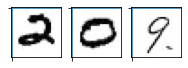

In [73]:
plt.figure(figsize = (16, 6))
for test_image in np.arange(3):
    plt.subplot(1, 15, test_image+1)
    plt.axhline('')
    plt.axvline('')
    plt.imshow(test_inputs[test_image].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

### 5.3 Prédictions

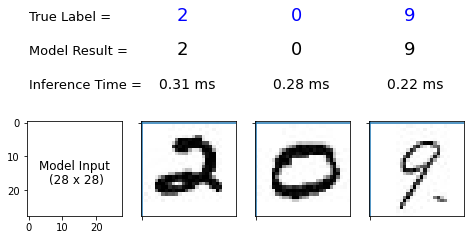

In [74]:
plt.figure(figsize = (16, 6), frameon=False)
plt.subplot(1, 8, 1)

plt.text(x = 0, y = -30, s = "True Label =", fontsize = 13, color = 'black')
plt.text(x = 0, y = -20, s = "Model Result =", fontsize = 13, color = 'black')
plt.text(x = 0, y = -10, s = "Inference Time =", fontsize = 13, color = 'black')
plt.text(x = 3, y = 14, s = "Model Input", fontsize = 12, color = 'black')
plt.text(x = 6, y = 18, s = "(28 x 28)", fontsize = 12, color = 'black')
plt.imshow(np.ones((28,28)), cmap=plt.cm.Greys)    


for i in np.arange(test_data_size):
    
    input_data = json.dumps({'data': test_inputs[i].tolist()})
    
    # predict using the deployed model
    r = aci_service.run(input_data)
    
    if "error" in r:
        print(r['error'])
        break
        
    result = r['result']
    time_ms = np.round(r['time_in_sec'] * 1000, 2)
    
    ground_truth = int(np.argmax(test_outputs[i]))
    
    # compare actual value vs. the predicted values:
    plt.subplot(1, 8, i+2)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if ground_truth != result else 'black'
    clr_map = plt.cm.gray if ground_truth != result else plt.cm.Greys

    # ground truth labels are in blue
    plt.text(x = 10, y = -30, s = ground_truth, fontsize = 18, color = 'blue')
    
    # predictions are in black if correct, red if incorrect
    plt.text(x = 10, y = -20, s = result, fontsize = 18, color = font_color)
    plt.text(x = 5, y = -10, s = str(time_ms) + ' ms', fontsize = 14, color = font_color)

    
    plt.imshow(test_inputs[i].reshape(28, 28), cmap = clr_map)

plt.show()

In [24]:
# Pour supprimer le service
#aci_service.delete()

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">